## Imports

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
import sys
sys.path.append('../../Models')
from models import LSTMPredictor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pymongo import MongoClient
from dotenv import load_dotenv
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

load_dotenv()
cluster_uri = os.environ.get("MONGODB_URI")
client = MongoClient(cluster_uri)
db = client["MSCI446_DB"]


## Functions

In [2]:
def create_sequences(features, target, sequence_length):
    sequences = []
    target_sequences = []
    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i+sequence_length])
        target_sequences.append(target[i+1:i+1+sequence_length])
   
    sequences = np.array(sequences, dtype=np.float32)
    target_sequences = np.array(target_sequences, dtype=np.float32)
    
    return torch.from_numpy(sequences), torch.from_numpy(target_sequences)


def kfold_validation(X, y, n_hidden_options, lr_options, drop_out_options, num_epochs, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_score = float('inf')
    best_params = {}

    for n_hidden in n_hidden_options:
        for lr in lr_options:
            for dropout_rate in drop_out_options:
                fold_scores = []
                for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                    print(f"Running Fold {fold + 1}/{k_folds}, n_hidden: {n_hidden}, lr: {lr}, dropout: {dropout_rate}")
            
                    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
                    
                    train_dataset = TensorDataset(X_train_fold, y_train_fold)
                    val_dataset = TensorDataset(X_val_fold, y_val_fold)
                    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
                    
                    model = LSTMPredictor(input_features=X_train_fold.shape[2], n_hidden=n_hidden, output_features=1, dropout_rate=dropout_rate).to(device)
                    criterion = nn.MSELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    
                    train_model(model, train_loader, criterion, optimizer, num_epochs, device)
                    
                    _, val_predictions, val_actuals = test_model(model, val_loader, criterion, device)
                    val_mae = mean_absolute_error(val_actuals.cpu().numpy(), val_predictions.cpu().numpy())
                    val_mse = mean_squared_error(val_actuals.cpu().numpy(), val_predictions.cpu().numpy())
                    val_r2 = r2_score(val_actuals.cpu().numpy(), val_predictions.cpu().numpy())
                    
                    fold_scores.append((val_mae, val_mse, val_r2))
   
                avg_mae = np.mean([score[0] for score in fold_scores])
                avg_mse = np.mean([score[1] for score in fold_scores])
                avg_r2 = np.mean([score[2] for score in fold_scores])
                print(f"Average MAE: {avg_mae:.4f}, Average MSE: {avg_mse:.4f}, Average R²: {avg_r2:.4f} for n_hidden: {n_hidden}, lr: {lr}, dropout: {dropout_rate}")
                
                if avg_mae < best_score:
                    best_score = avg_mae
                    best_params = {'n_hidden': n_hidden, 'lr': lr, 'dropout_rate': dropout_rate}

    return best_params, best_score

def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0  
        for seq, targets in train_loader:
            seq, targets = seq.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(seq).to(device)
            output = output.unsqueeze(-1)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)  
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')
    return train_losses

def test_model(model, test_loader, criterion, device, future=0):
    model.eval()
    predictions = []
    actuals = []
    test_losses = []
    total_loss = 0
    index = 0
    with torch.no_grad():
        for seq, targets in test_loader:
            seq, targets = seq.to(device), targets.to(device)
            output = model(seq, future=future).to(device)
            if future > 0:
               
                extended_targets = torch.cat([targets, torch.zeros(targets.size(0), future, 1, device=device)], dim=1)
            else:
                extended_targets = targets
            
           
            output = output.unsqueeze(-1)
            loss = criterion(output, extended_targets)
            total_loss += loss.item()
            test_losses.append(loss.item())
            predictions.append(output.cpu())
            actuals.append(extended_targets.cpu())
            index += 1
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss}')
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)
    return test_losses, predictions, actuals

def test_model_and_calc_metrics(model, test_loader, criterion, device, future=0):
    model.eval()
    predictions = []
    actuals = []
    test_losses = []
    total_loss = 0
    sequence_metrics = []  

    with torch.no_grad():
        for seq, targets in test_loader:
            seq, targets = seq.to(device), targets.to(device)
            output = model(seq, future=future).to(device)
            
            if future > 0:
                extended_targets = torch.cat([targets, torch.zeros(targets.size(0), future, 1, device=device)], dim=1)
            else:
                extended_targets = targets
            
            output = output.unsqueeze(-1)
            loss = criterion(output, extended_targets)
            total_loss += loss.item()
            test_losses.append(loss.item())

            predictions.append(output.cpu())
            actuals.append(extended_targets.cpu())

            for pred, actual in zip(output, extended_targets):
                pred_np = pred.cpu().squeeze(-1).numpy()
                actual_np = actual.cpu().squeeze(-1).numpy()
                mae = mean_absolute_error(actual_np, pred_np)
                mse = mean_squared_error(actual_np, pred_np)
                r2 = r2_score(actual_np, pred_np)
                sequence_metrics.append((mae, mse, r2))

    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss}')
    
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return sequence_metrics, test_losses, predictions, actuals


def predict_future(model, input_sequence, device, future_steps=1):
    model.eval()  
    predictions = []

    with torch.no_grad(): 
        for seq, targets in input_sequence:
            seq, targets = seq.to(device), targets.to(device)
            pred = model(seq, future=future_steps)
            
            predictions.append(pred)
        
      
        predictions = torch.cat(predictions, dim=0)

    return predictions



def print_metrics(actuals, predictions):
    r2 = r2_score(actuals.squeeze(-1).numpy(), predictions.squeeze(-1).numpy())
    mae = mean_absolute_error(actuals.squeeze(-1).numpy(),predictions.squeeze(-1).numpy())
    print(f'R² Score: {r2}')
    print(f'Mean Absolute Error: {mae}')

def print_sequence_metrics(sequence_metrics):
    for i, (mae, mse, r2) in enumerate(sequence_metrics, 1):
        print(f"Sequence {i}: MAE = {mae:.3f}, MSE = {mse:.3f}, R² = {r2:.3f}")

def calculate_and_print_average_metrics(sequence_metrics):
    total_mae, total_mse, total_r2 = 0, 0, 0
    for mae, mse, r2 in sequence_metrics:
        if (r2 < 0):
            r2 = 0
        total_mae += mae
        total_mse += mse
        total_r2 += r2

    
    avg_mae = total_mae / len(sequence_metrics)
    avg_mse = total_mse / len(sequence_metrics)
    avg_r2 = total_r2 / len(sequence_metrics)

    
    print(f"Average MAE = {avg_mae:.3f}")
    print(f"Average MSE = {avg_mse:.3f}")
    print(f"Average R² = {avg_r2:.3f}")

def print_best_sequence_metrics(sequence_metrics):
   
    best_mae = float('inf')
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_mae_seq = best_mse_seq = best_r2_seq = 0

    for i, (mae, mse, r2) in enumerate(sequence_metrics, start=1):
        if mae < best_mae:
            best_mae = mae
            best_mae_seq = i
        if mse < best_mse:
            best_mse = mse
            best_mse_seq = i
        if r2 > best_r2:
            best_r2 = r2
            best_r2_seq = i

    print(f"Best MAE: {best_mae:.3f} (Sequence {best_mae_seq})")
    print(f"Best MSE: {best_mse:.3f} (Sequence {best_mse_seq})")
    print(f"Best R²: {best_r2:.3f} (Sequence {best_r2_seq})")
   



def plot_predictions(predictions, actuals, num_sequences=5):
    for i in range(min(num_sequences, predictions.size(0))):
        df = pd.DataFrame(data={
            'Time Step': list(range(predictions.size(1))) * 2,
            'Value': torch.cat((actuals[i, :, 0], predictions[i, :, 0]), dim=0).numpy(),
            'Type': ['Actual'] * predictions.size(1) + ['Predicted'] * predictions.size(1)
        })

        plt.figure(figsize=(10, 4))
        plt.title(f'Sequence {i+1}')
        sns.lineplot(x='Time Step', y='Value', hue='Type', style='Type', markers=True, dashes=False, data=df)
        plt.legend(title='Type')
        plt.show()
    
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.show()

def plot_training_loss(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()



## Loading Data

In [3]:
data = pd.read_csv('../Data/Final_table.csv')


# collection_merged = db["Merged"]
# data = pd.DataFrame(list(collection_merged.find()))
# data = data.drop(columns=['_id'])
data.head()


,datetime_beginning_ept,MIDATL_solar,OTHER_solar,RFC_solar,RTO_solar,SOUTH_solar,WEST_solar,MIDATL_wind,OTHER_wind,RFC_wind,...,DOM_forecast,DUQ_forecast,EKPC_forecast,MIDATL_forecast,RTO_forecast,DPL_historical_da,forecast_gen_outage_mw_rto,forecast_gen_outage_mw_west,forecast_gen_outage_mw_other,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
0,19/02/2022 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,543.833,0.0,7749.579,...,13124.200000,1428.2,1825.200000,29872.800000,90802.0,38.95,3216.836735,267.714286,2949.122449,4.61
1,19/02/2022 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,631.555,0.0,7669.941,...,13098.200000,1399.4,1818.400000,29506.400000,89577.4,36.43,3216.836735,267.714286,2949.122449,4.61
2,19/02/2022 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,736.464,0.0,7726.962,...,13255.800000,1381.4,1824.600000,29435.800000,89291.6,36.36,3216.836735,267.714286,2949.122449,4.61
3,19/02/2022 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,783.231,0.0,7896.692,...,13455.400000,1375.4,1831.400000,29589.800000,89587.8,36.59,3216.836735,267.714286,2949.122449,4.61
4,19/02/2022 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,860.240,0.0,8150.219,...,13840.333333,1384.5,1882.333333,30146.166667,91159.0,38.60,3216.836735,267.714286,2949.122449,4.61


## Scaling Features and Target Value

In [4]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data.drop(columns=['datetime_beginning_ept', 'DPL_historical_da']))
scaled_target = scaler.fit_transform(data[['DPL_historical_da']])

## Creating Sequences

In [5]:
X, y = create_sequences(scaled_features, data[['DPL_historical_da']], sequence_length=72)

## Splitting into Train and Test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

## Feature Selection

In [7]:
n_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape((n_samples * n_timesteps, n_features))
y_train_reshaped = y_train.reshape((n_samples * n_timesteps,))


model_fr = SelectKBest(score_func=f_regression, k=5)

data_new_fr = model_fr.fit(X_train_reshaped, y_train_reshaped)

#print("f_regression: ", data_new_fr.get_feature_names_out())

feature_names = data.drop(columns=['datetime_beginning_ept', 'DPL_historical_da']).columns.tolist()

selected_features_mask = model_fr.get_support()
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_features_mask[i]]
print("Selected features:", selected_feature_names)

Selected features: ['APS_forecast', 'DOM_forecast', 'MIDATL_forecast', 'RTO_forecast', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)']


In [8]:
X_train_best = model_fr.transform(X_train_reshaped)  
X_test_best = model_fr.transform(X_test.reshape((X_test.shape[0] * X_test.shape[1], X_test.shape[2])))

X_train_best = X_train_best.reshape((X_train.shape[0], X_train.shape[1], -1))
X_test_best = X_test_best.reshape((X_test.shape[0], X_test.shape[1], -1))

## Converting to Valid Pytorch Input

In [9]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
train_dataset_best = TensorDataset(torch.from_numpy(X_train_best), y_train)
train_loader_best = DataLoader(train_dataset_best, batch_size=64, shuffle=False)

test_dataset_best = TensorDataset(torch.from_numpy(X_test_best), y_test)
test_loader_best = DataLoader(test_dataset_best, batch_size=64, shuffle=False)

## K-fold-cross-validation

In [11]:
# n_hidden_options = [16, 32, 50, 64, 128]
# lr_options = [0.1, 0.01, 0.05, 0.001, 0.0001]
# drop_out_options = [0.1, 0.2, 0.3, 0.4, 0.5]
# num_epochs = 50

# best_params, best_score = kfold_validation(X, y, n_hidden_options, lr_options, drop_out_options, num_epochs)

# print(f"Best Hyperparameters: {best_params}")
# print(f"Best Validation Score: {best_score}")


## **Note**

### I tried to do 5 K-fold cross validation but due to time constraints it would take too long to run, so the code has been commented

## Training Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_best = LSTMPredictor(input_features=X_train_best.shape[2], n_hidden=best_params['n_hidden'], output_features=1, dropout_rate = best_params['dropout_rate']).to(device)
model_best = LSTMPredictor(input_features=X_train_best.shape[2], n_hidden= 51, output_features=1).to(device)


criterion = nn.MSELoss()
# optimizer_adam = optim.Adam(model_best.parameters(), lr=best_params['lr_options'])
optimizer_adam = optim.Adam(model_best.parameters(), lr=0.001)
num_epochs = 75
train_losses_best = train_model(model_best, train_loader_best, criterion, optimizer_adam, num_epochs, device)

Epoch 1, Average Loss: 5114.364085955953
Epoch 2, Average Loss: 4389.257749921222
Epoch 3, Average Loss: 3892.2334573169087
Epoch 4, Average Loss: 3546.148079069271
Epoch 5, Average Loss: 3310.6856371147687
Epoch 6, Average Loss: 3154.0098870299585
Epoch 7, Average Loss: 3051.9621685915217
Epoch 8, Average Loss: 2986.77100535548
Epoch 9, Average Loss: 2945.8013296615245
Epoch 10, Average Loss: 2920.375296570534
Epoch 11, Average Loss: 2904.7239187018818
Epoch 12, Average Loss: 2895.121105744118
Epoch 13, Average Loss: 2889.2172088977904
Epoch 14, Average Loss: 2885.5556865603426
Epoch 15, Average Loss: 2883.2370744217274
Epoch 16, Average Loss: 2881.6815403960472
Epoch 17, Average Loss: 2880.5433450210926
Epoch 18, Average Loss: 2879.5484614172647
Epoch 19, Average Loss: 2798.8903953729673
Epoch 20, Average Loss: 2694.9625357783116
Epoch 21, Average Loss: 2561.929330093916
Epoch 22, Average Loss: 2471.3219359996706
Epoch 23, Average Loss: 2379.183257045302
Epoch 24, Average Loss: 2311.

## Plotting Train Loss

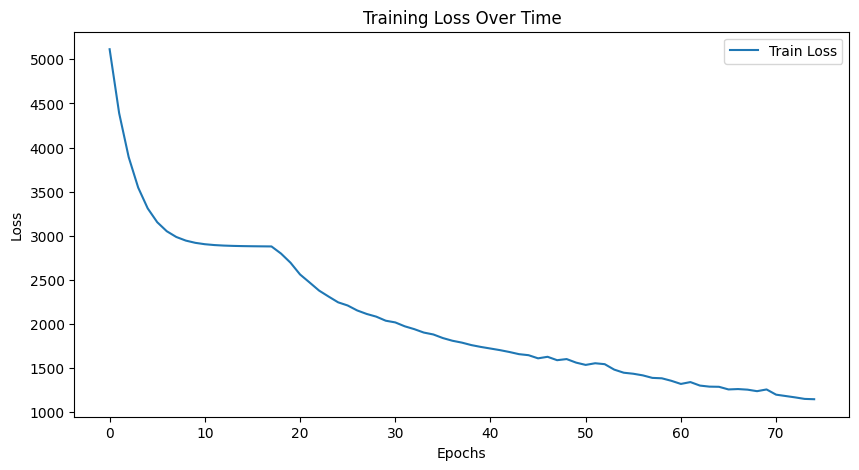

In [13]:
plot_training_loss(train_losses_best)

In [14]:
sequence_metrics, test_losses, predictions, actuals = test_model_and_calc_metrics(model_best, test_loader_best, criterion, device, future=0)

Test Loss: 1259.8233933625397


## Metrics

### Treating the Data As Hourly

In [15]:
print_metrics(actuals, predictions)

R² Score: 0.1062826499437404
Mean Absolute Error: 17.106061935424805


### Treating the Data As Sequential Points

#### Sequential Metrics For Each Sequence 

In [16]:
print_sequence_metrics(sequence_metrics)

Sequence 1: MAE = 3.510, MSE = 18.201, R² = 0.411
Sequence 2: MAE = 3.496, MSE = 17.999, R² = 0.436
Sequence 3: MAE = 3.800, MSE = 21.425, R² = 0.351
Sequence 4: MAE = 4.356, MSE = 32.929, R² = 0.034
Sequence 5: MAE = 4.715, MSE = 43.880, R² = -0.243
Sequence 6: MAE = 4.797, MSE = 45.965, R² = -0.266
Sequence 7: MAE = 4.734, MSE = 40.043, R² = -0.107
Sequence 8: MAE = 4.518, MSE = 32.339, R² = 0.075
Sequence 9: MAE = 4.276, MSE = 26.427, R² = 0.212
Sequence 10: MAE = 4.156, MSE = 23.053, R² = 0.277
Sequence 11: MAE = 4.193, MSE = 22.507, R² = 0.288
Sequence 12: MAE = 4.253, MSE = 23.619, R² = 0.269
Sequence 13: MAE = 4.412, MSE = 25.953, R² = 0.214
Sequence 14: MAE = 4.611, MSE = 29.935, R² = 0.113
Sequence 15: MAE = 4.732, MSE = 32.194, R² = 0.066
Sequence 16: MAE = 4.831, MSE = 33.567, R² = 0.011
Sequence 17: MAE = 4.901, MSE = 34.107, R² = -0.049
Sequence 18: MAE = 4.900, MSE = 33.764, R² = -0.151
Sequence 19: MAE = 4.950, MSE = 34.918, R² = -0.508
Sequence 20: MAE = 4.963, MSE = 35

#### Average of All the Sequences

In [17]:
calculate_and_print_average_metrics(sequence_metrics)

Average MAE = 17.106
Average MSE = 1268.484
Average R² = 0.039


#### Best Metrics

In [18]:
print_best_sequence_metrics(sequence_metrics)

Best MAE: 2.898 (Sequence 3209)
Best MSE: 12.730 (Sequence 3209)
Best R²: 0.499 (Sequence 3022)


## Plotting Results

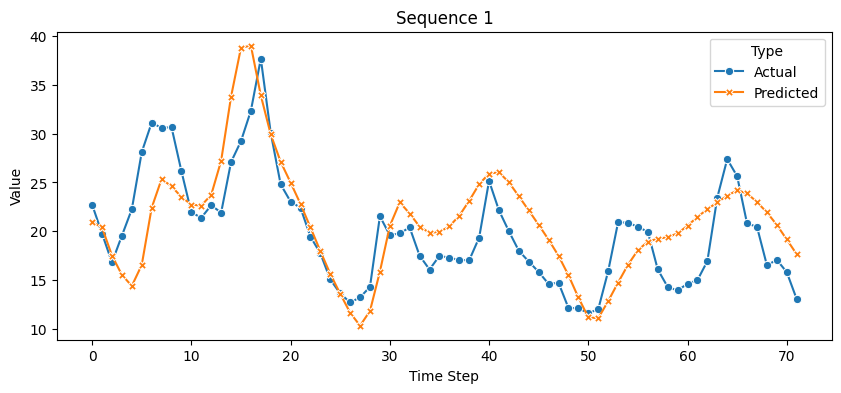

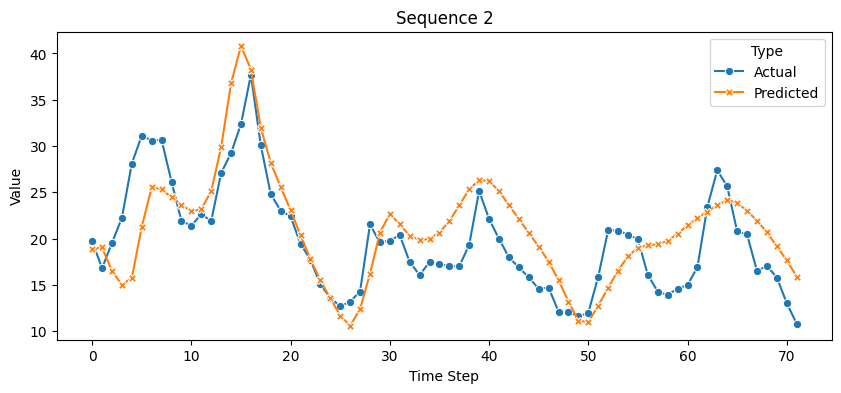

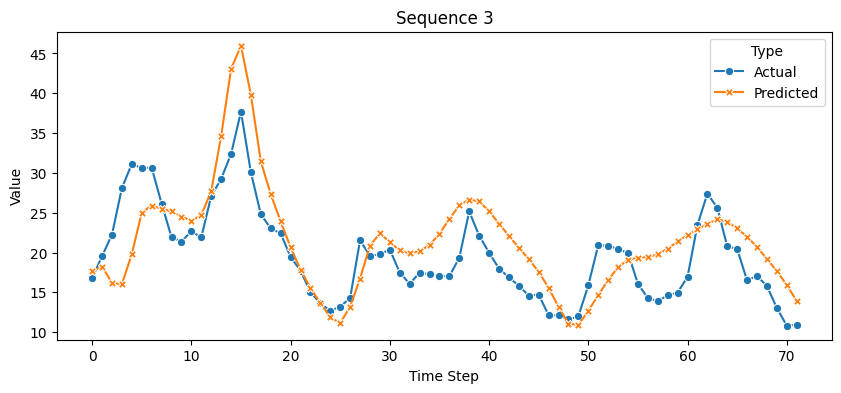

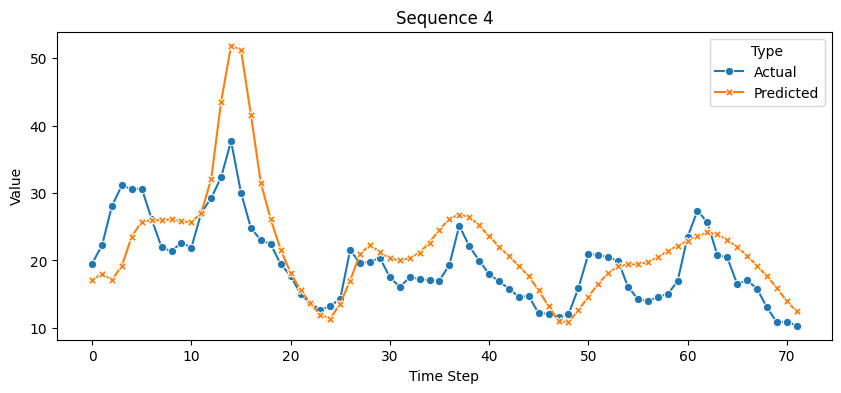

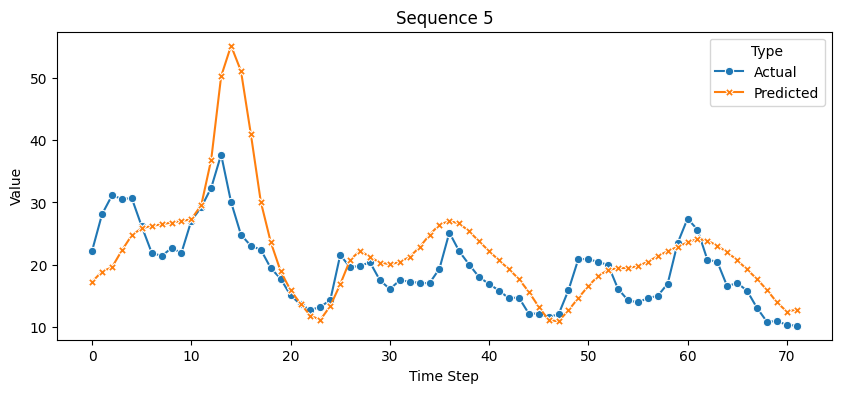

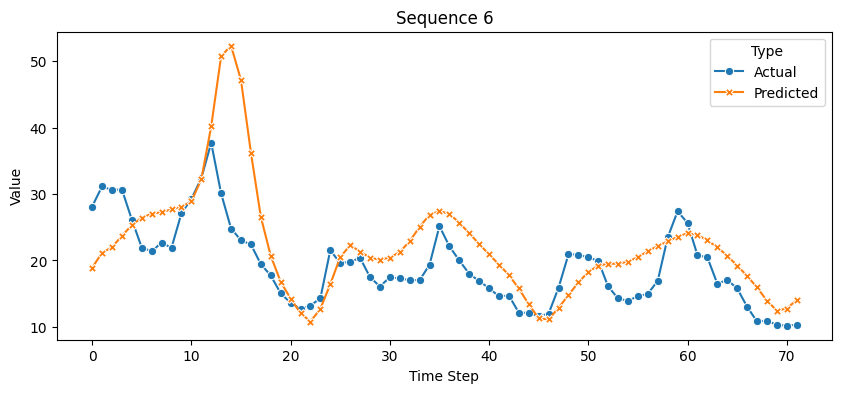

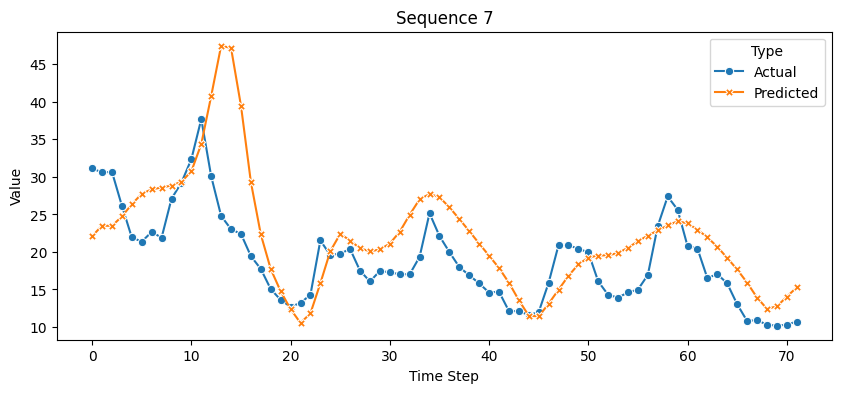

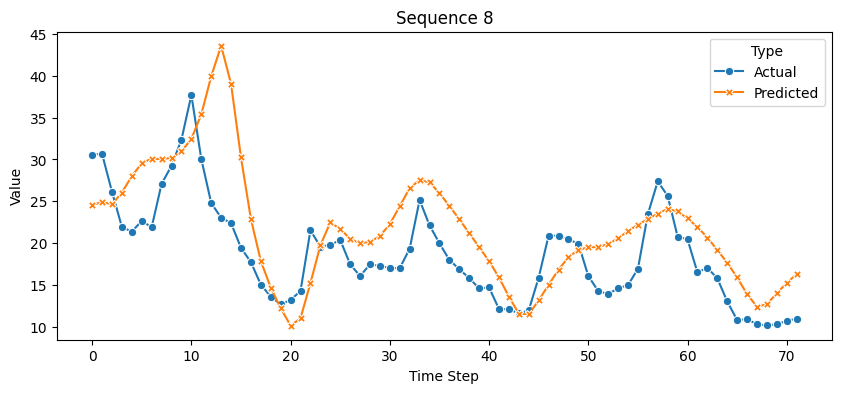

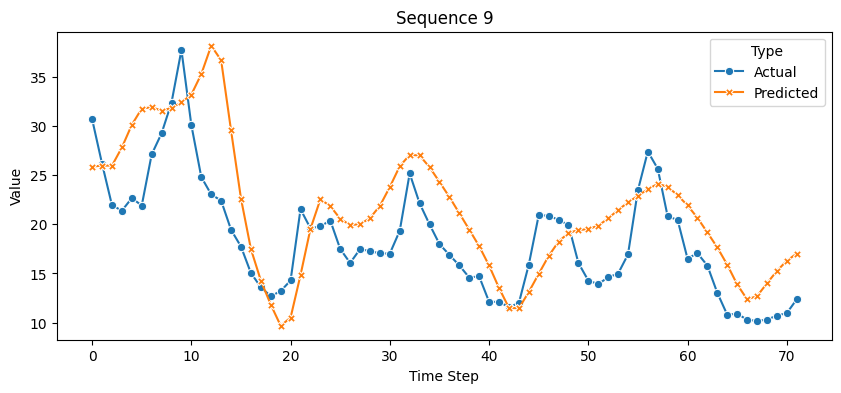

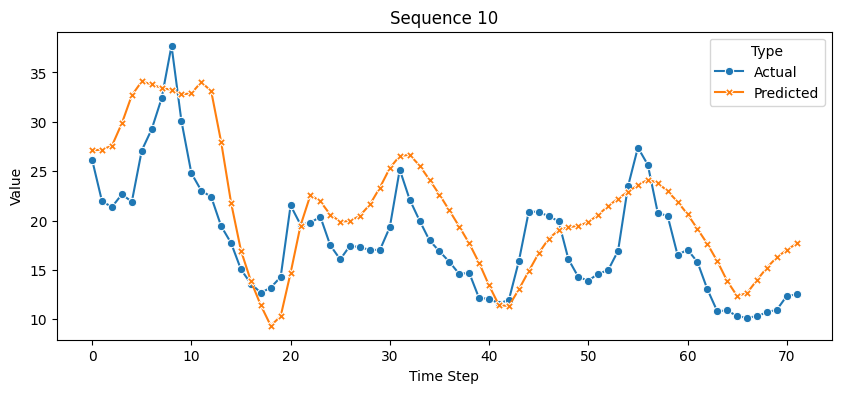

In [19]:
plot_predictions(predictions, actuals, num_sequences=10)

## Predicting Future Values

In [20]:
future_values = predict_future(model_best, test_loader_best, device, future_steps=10)
future_predictions = future_values[:, -10:]

future_predictions_2d = future_predictions.reshape(-1, 1)

# Inverse transform to get back to the original dollar values
unscaled_future_predictions = scaler.inverse_transform(future_predictions_2d)

# Reshape back to the original shape with future predictions
unscaled_future_predictions = unscaled_future_predictions.reshape(future_predictions.shape)

In [21]:
for i, future_values in enumerate(future_predictions):
    print(f"Future Values for Sequence {i+1}:")
    print(f"Unscaled: {future_values}")
    print("\n") 

Future Values for Sequence 1:
Unscaled: tensor([124.0173, 142.2627, 148.7798, 153.9922, 158.2484, 160.2486, 160.6430,
        160.7008, 160.7147, 160.7597])


Future Values for Sequence 2:
Unscaled: tensor([124.6162, 142.5632, 149.1344, 154.6816, 158.8889, 160.4029, 160.6661,
        160.7045, 160.7190, 160.7872])


Future Values for Sequence 3:
Unscaled: tensor([125.5448, 143.2818, 150.0847, 156.2669, 159.7569, 160.5675, 160.6899,
        160.7098, 160.7346, 160.8926])


Future Values for Sequence 4:
Unscaled: tensor([126.2140, 144.3179, 152.1763, 158.3866, 160.3386, 160.6576, 160.7040,
        160.7237, 160.8213, 161.4431])


Future Values for Sequence 5:
Unscaled: tensor([125.6353, 145.0966, 153.8115, 159.1839, 160.4818, 160.6783, 160.7098,
        160.7460, 160.9718, 162.2321])


Future Values for Sequence 6:
Unscaled: tensor([123.8900, 144.6593, 153.1047, 158.8614, 160.4258, 160.6701, 160.7064,
        160.7289, 160.8554, 161.6385])


Future Values for Sequence 7:
Unscaled: tensor

## **Note**

### Tried to protect a N number of future steps but was not able to get it working in time, created a work around but very inaccurate

## Saving Model

In [22]:
# torch.save(model_best.state_dict(), '../Models/model_LSTM.pth') # Save the model